In [0]:
################################################################################
# %% CONNECT TO DRIVE
################################################################################

from google.colab import drive, files
drive.mount('/content/drive')

In [1]:
################################################################################
# %% IMPORT PACKAGES
################################################################################

import os
import glob
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import sys
from time import time
import matplotlib.pyplot as mp
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam

In [0]:
################################################################################
# %% LOAD DATA AND SPLIT  <-- TO BE MOVED INTO GENERATOR!
################################################################################

def generate_data(dpath):
    
    fimg = sorted(glob.glob(dpath+'image-train*'))
    flbl = sorted(glob.glob(dpath+'label-train*'))
    i = 0
    while True:
        X = np.load(fimg[i])
        y = np.load(flbl[i])
        #chunks = np.int(np.floor(len(X)/batch_size))
        #for j in range(chunks):
        #  X_scaled = X[j*batch_size:(j+1)*batch_size, :, :, :]/255.0
        #  y_scaled = y[j*batch_size:(j+1)*batch_size, :, :, :]
        yield X[:128,:,:,:]/255.0, y[:128,:,:,:]
        #yield X/255.0, y
        if i<len(fimg)-1:
            i += 1
        else:
            i = 0

gen = generate_data('drive/My Drive/Data/')

#X = np.load('drive/My Drive/Data/image-train-0.npy')
#y = np.load('drive/My Drive/Data/label-train-0.npy')
#X_train, X_test, y_train, y_test = train_test_split(X,y)
#X = None
#y = None

In [0]:
################################################################################
# %% NORMALIZE INPUT DATA
################################################################################

#X_train = X_train/255.0
#X_test = X_test/255.0

In [0]:
"""
################################################################################
# %% CONNECT TO TPU
################################################################################

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
"""

In [0]:
################################################################################
# %% UNET MODEL
################################################################################

def unet_model(power=2):
  
  input_size = (256,256,3)

  inputs = Input(input_size)
  conv1 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(2**(power+4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(2**(power+4), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(2**(power+3), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation='bilinear')(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(2**(power+3), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(2**(power+2), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(2**(power+2), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(2**(power+1), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(2**(power+1), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(2**(power), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation='bilinear')(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(2**(power), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = keras.Model(inputs = inputs, outputs = conv10)
  return model

In [4]:
"""
################################################################################
# %% BUILD AND COMPILE FOR TPU
################################################################################

with strategy.scope():
"""

################################################################################
# %% BUILD UNET MODEL
################################################################################

model = unet_model(4)
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (Max

In [0]:
################################################################################
# %% INIT CALLBACKS
################################################################################

#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()), update_freq='epoch')
earlystopping = EarlyStopping(monitor='loss', patience=100)
modelcheckpoint = ModelCheckpoint('keras_model_checkpoint.h5', monitor='loss',verbose=1, save_best_only=True, save_freq='epoch')

In [19]:
################################################################################
# %% RUN MODEL
################################################################################

history = model.fit_generator( 
    gen,
    steps_per_epoch = 11,
    #x=X_train,
    #y=y_train,
    epochs=1000,
    verbose=1,
    #validation_data=(X_test, y_test),
    use_multiprocessing=True,
    #batch_size=16,
    callbacks=[earlystopping, modelcheckpoint] #tensorboard
)

model.save('keras_model.h5')

Epoch 1/1000
 8/11 [====================>.........] - ETA: 3s - loss: 0.1254 - acc: 0.9524

Process Keras_worker_ForkPoolWorker-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
KeyboardInterrupt


Epoch 1/1000


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 463, in _handle_results
    task = get()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
_pickle.UnpicklingError: invalid load key, '\x9b'.



KeyboardInterrupt: ignored

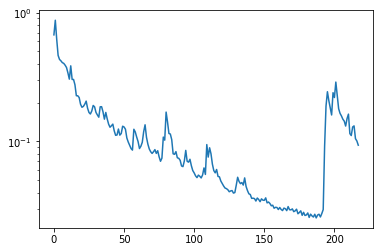

In [8]:
################################################################################
# %% PLOTTING LOSS CURVE
################################################################################

#mp.semilogy(abs(np.array(history.history['acc'])-1))
mp.semilogy(history.history['loss'])

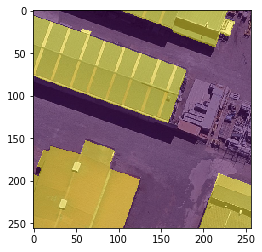

In [16]:
################################################################################
# %% PLOTTING BASE TRUTH
################################################################################

X_test = np.load('drive/My Drive/Data/image-train-0.npy')
y_test = np.load('drive/My Drive/Data/label-train-0.npy')

id = 63

mp.imshow(X_test[id,:,:,:])
mp.imshow(y_test[id,:,:,0], alpha=0.5)
mp.show()

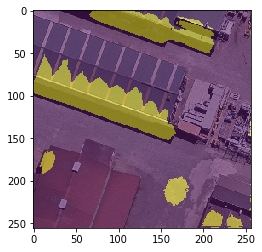

In [17]:
################################################################################
# %% PLOTTING PREDICTION ON TRAINING DATA
################################################################################

X_pred = X_test[id]
X_pred = X_pred[np.newaxis]
y_pred = model.predict(X_pred)

mp.imshow(X_pred[0])
mp.imshow(y_pred[0, :, :, 0]>0.5, alpha=0.5)
mp.show()